# Punto 3

## Suma de números aleatorios

Un ejemplo interesante que muestra la distribución de los P-valores es la suma de números aleatorios. En este caso sumamos M números entre 0 y 1, para luego dividir esa suma entre M, asegurando así que el resultado esté de nuevo entre 0 y 1. Se puede observar que al hacer ese experimento varias veces (N veces), se logra una distribución normal alrededor de 0.5. Así calculamos el P-valor repitiendo el proceso L veces. A continuación se muestran los resultados.

In [1]:
% pylab inline
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
def lanzamientos3(M,N,L):
    return sum(random.random((M,N,L)),axis=0)/M

M=50
N=100
L=10000

prueba = lanzamientos3(M,N,L)

index=arange(L)
t_values,p_value = stats.ttest_1samp(prueba[:,index],0.5)

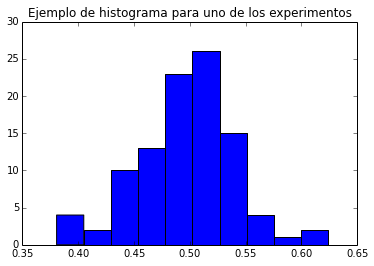

In [16]:
hist(prueba[:,2])
title(u"Ejemplo de histograma para uno de los experimentos")

Arriba se puede ver uno de los experimentos, mostrando la distribución normal alrededor de 0.5
Abajo los histogramas para los valores de t\* y los P-valores

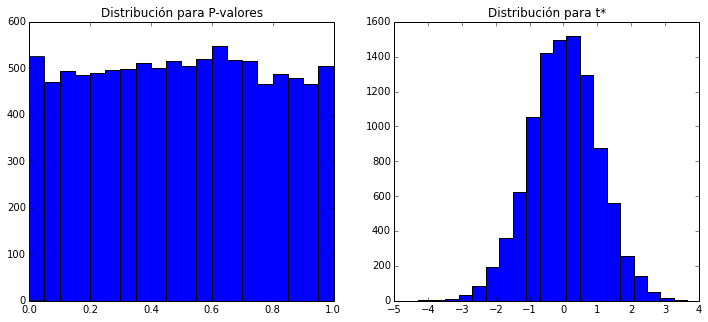

In [25]:
figure(figsize=(12,5))
subplot(1,2,1)
hist(p_value,bins=20)
title(u"Distribución para P-valores")
subplot(1,2,2)
hist(t_values,bins=20)
title(u"Distribución para t*")

Se puede ver la distribución esperada para t y una distribución homogénea para los P-valores, que es razonable teniendo en cuenta la naturaleza del experimento. Los valores mínimos, máximos y promedio para los P-valores se pueden ver abajo. Se graficó el promedio de valor mínimo/máximo/medio del P-valor calculado 100 veces para cada tamaño de la muestra entre $2$ y $2^9$

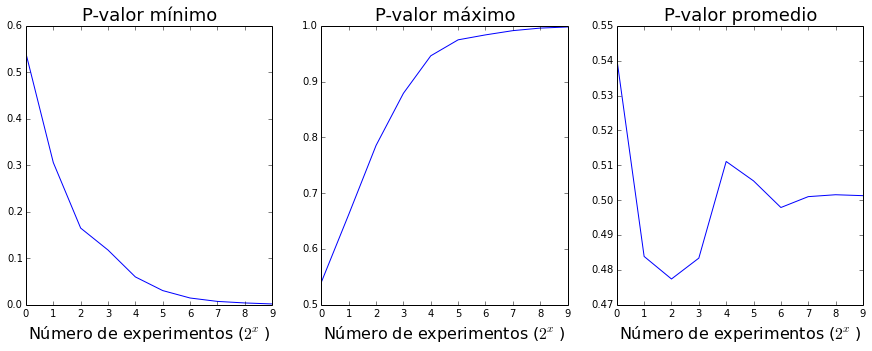

In [88]:
pot_max=10
veces=100
p_min_av,p_max_av,p_mean_av=[],[],[]
for i in range(pot_max):
    p_min,p_max,p_mean=[],[],[]
    for j in range(veces):
        M=50
        N=10
        L=2**i
        prueba = lanzamientos3(M,N,L)
        index=arange(L)
        t_values,p_value = stats.ttest_1samp(prueba[:,index],0.5)
        p_min.append(min(p_value))
        p_max.append(max(p_value))
        p_mean.append(mean(p_value))
    p_min_av.append(mean(p_min))
    p_max_av.append(mean(p_max))
    p_mean_av.append(mean(p_mean))
figure(figsize=(15,5))
subplot(1,3,1)
plot(p_min_av)
title(u"P-valor mínimo",fontsize=18)
xlabel(u'Número de experimentos ($2^x$)', fontsize=16)
subplot(1,3,2)
plot(p_max_av)
title(u"P-valor máximo",fontsize=18)
xlabel(u'Número de experimentos ($2^x$)', fontsize=16)
subplot(1,3,3)
plot(p_mean_av)
title(u"P-valor promedio",fontsize=18)
xlabel(u'Número de experimentos ($2^x$)', fontsize=16)

Así se puede tener idea del número mínimo de veces que sería necesario repetir el experimento para asegurar encontra al menos uno con un resultado estadísticamente significatico (*P-hacking*), en este caso del orden de $2^5$ si se quiere P-valor cercano a 0.05

## Algoritmo de Gillespie

Otro ejemplo muy interesante se puede ver con el algoritmo de Gillespie, usado para simular la creación/destrucción de RNAa y proteínas. En este caso, primeramente comparamos con la solución numérica a la ecuación. Esta solución es continua por supuesto, mientras que en la realidad se trata de un proceso discretizado: no se puede encontrar fracciones de proteínas o RNAs. Nuestra hipótesis será que efectivamente los datos se encuentren alrededor de los valores de equilibrio, para este caso 10 y 5000 para RNAs y proteínas respectivamente.

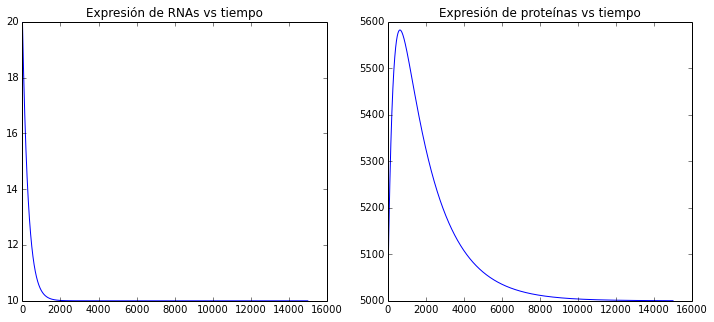

In [89]:
dt=0.1
r0=20
p0=5000
steps=150000
tiempo=linspace(0,steps*dt,steps)

gamma_r=1./(60*5.)
gamma_p=1./(60*30.)
k_r=10.*gamma_r
k_p=500.*gamma_p

"""
k=1.  #steady=k/gamma
gamma=1./5
gamma_p=1./30
k_p=1000./30
"""

r=[]
p=[]
r.append(r0)
p.append(p0)
for i in range(steps-1):
    r.append(r[i]+(k_r-gamma_r*r[i])*dt)
    p.append(p[i]+(k_p*r[i]-gamma_p*p[i])*dt)

figure(figsize=(12,5))
subplot(1,2,1)
title(u"Expresión de RNAs vs tiempo")
plot(tiempo,r)
subplot(1,2,2)
title(u"Expresión de proteínas vs tiempo")
plot(tiempo,p)


Como se puede ver, las curvas tienden rápidamente a un valor estacionario ($k/\gamma$) para los RNAs y similarmente para las proteínas). Así, usaremos el algoritmo de Gillespie para simular el proceso durante un tiempo relativamente largo. Luego de eso seleccionaremos aleatoriamente una muestra de varios momentos en que mediremos la expresión (el número) de la proteína. Esto es válido pues esta evolución en el tiempo, en estado estacionario, es equivalente a medir el estado de muchas células en un momento dado (hipótesis ergódica).

In [90]:
def gillespie():
    gamma=1./(60*5.)
    gamma_p=1./(60*30.)
    k=10.*gamma
    k_p=500.*gamma_p

    """
    k=1.  #steady=k/gamma
    gamma=1./5
    gamma_p=1./30
    k_p=1000./30
    """

    steps=500000
    tiempo=linspace(0.,steps,steps+1)
    r,p=zeros(size(tiempo)),zeros(size(tiempo))
    r[0],p[0],tiempo[0]=5,5000,0.
    dt=[]
    for i in range(size(tiempo)-1):
        T_cr=k
        T_des=gamma*r[i]
        T3=k_p*r[i]
        T4=gamma_p*p[i]
        T_tot=T_cr+T_des+T3+T4
        t=-1./T_tot*(log(random.random()))
        dt.append(t)
        tiempo[i+1]=tiempo[i]+t
        x=random.random()
        if x<(T_cr/T_tot):
            r[i+1]=r[i]+1
            p[i+1]=p[i]
        elif x<(T_cr+T_des)/T_tot:
            r[i+1]=r[i]-1
            p[i+1]=p[i]
        elif x<(T_cr+T_des+T3)/T_tot:
            r[i+1]=r[i]
            p[i+1]=p[i]+1
        else:
            r[i+1]=r[i]
            p[i+1]=p[i]-1
    return r,p

In [91]:
r,p=gillespie()

In [92]:
index=random.randint(0,len(p),size=(20,10000))
t_values2,p_value2 = stats.ttest_1samp(p[index[:]],5000)

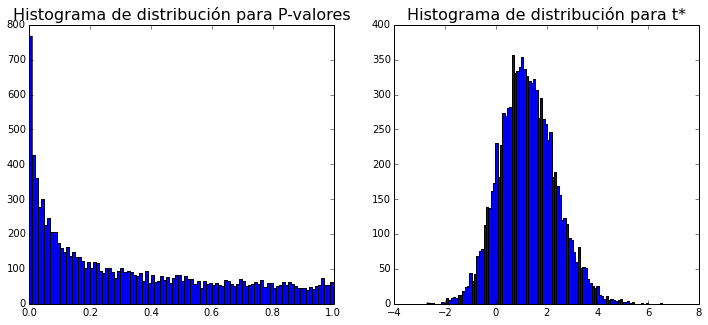

In [96]:
figure(figsize=(12,5))
subplot(1,2,1)
hist(p_value2,bins=100)
title(u"Histograma de distribución para P-valores",fontsize=16)
subplot(1,2,2)
hist(t_values2,bins=100)
title(u"Histograma de distribución para t*",fontsize=16)

En este caso la distribución es claramente bastante asimétrica, mostrando que la hipótesis en este caso era bastante más razonable, pero no por eso escapa de la naturaleza estocástica de los P-valores. La media para P-valores en este caso es

In [104]:
mean(p_value2)

0.33015750840164082

Ahora para analizar el comportamiento en función del número de experimentos lo hacemos similar al caso anterior.

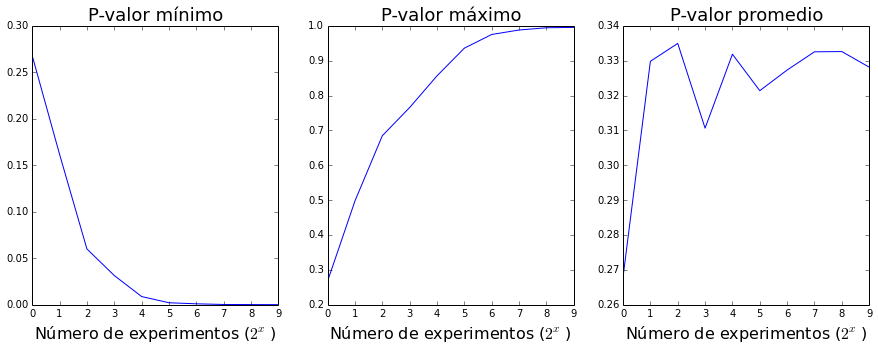

In [103]:
pot_max2=10
veces=30
p_min2_av,p_max2_av,p_mean2_av=[],[],[]
for i in range(pot_max):
    p_min2,p_max2,p_mean2=[],[],[]
    for j in range(veces):
        L=2**i
        index2=random.randint(0,len(p),size=(20,L))
        t_values2,p_value2 = stats.ttest_1samp(p[index2[:]],5000)
        
        p_min2.append(min(p_value2))
        p_max2.append(max(p_value2))
        p_mean2.append(mean(p_value2))
    p_min2_av.append(mean(p_min2))
    p_max2_av.append(mean(p_max2))
    p_mean2_av.append(mean(p_mean2))
figure(figsize=(15,5))
subplot(1,3,1)
plot(p_min2_av)
title(u"P-valor mínimo",fontsize=18)
xlabel(u'Número de experimentos ($2^x$)', fontsize=16)
subplot(1,3,2)
plot(p_max2_av)
title(u"P-valor máximo",fontsize=18)
xlabel(u'Número de experimentos ($2^x$)', fontsize=16)
subplot(1,3,3)
plot(p_mean2_av)
title(u"P-valor promedio",fontsize=18)
xlabel(u'Número de experimentos ($2^x$)', fontsize=16)

Y observamos que en este caso, como se podría esperar, el número mínimo de experimentos necesarios para asegurar un resultado estadísticamente significatico es bastante más bajo.